In [1]:
# Imports

import math
import numpy as np
from matplotlib import pyplot as plt
from numpy import random as rnd
import warnings,datetime,os,calendar,csv,time

import tensorflow as tf
import pandas as pd
import seaborn as sns

from keras.models import Model,Sequential
from keras.layers import Dense,LSTM,Conv2D,Dropout,BatchNormalization,Input,concatenate,Add,Activation,MaxPooling2D,AveragePooling2D,Flatten
import keras.backend as K

from sklearn import preprocessing as pp

from sklearn.cluster import KMeans,MeanShift
from sklearn.dummy import DummyClassifier,DummyRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier,AdaBoostRegressor,RandomForestClassifier,RandomForestRegressor
from sklearn.linear_model import BayesianRidge,Lasso,LinearRegression,SGDClassifier,SGDRegressor
from sklearn.mixture import BayesianGaussianMixture,GaussianMixture
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor,RadiusNeighborsClassifier,RadiusNeighborsRegressor,NearestNeighbors
from sklearn.manifold import Isomap,TSNE
from sklearn.model_selection import KFold,StratifiedKFold,train_test_split
from sklearn.svm import LinearSVC,LinearSVR
from sklearn.neural_network import BernoulliRBM,MLPClassifier,MLPRegressor
from sklearn.decomposition import FactorAnalysis,KernelPCA,PCA,MiniBatchSparsePCA,FastICA
from sklearn.preprocessing import CategoricalEncoder,KBinsDiscretizer,LabelEncoder,MinMaxScaler,OneHotEncoder,StandardScaler

from xgboost import XGBClassifier,XGBRegressor

import pickle,h5py,json

import pandas_datareader as pdr
import urllib
from bs4 import BeautifulSoup
import iexfinance as iex
from iexfinance.stocks import get_historical_data
from scipy.signal import resample,correlate
from scipy import fftpack

warnings.filterwarnings('ignore')
sns.set()
plt.xkcd()

C:\Users\Jan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Preliminary: Load data

In [3]:
def nanmean(x):
    m = 0
    ctr = 0
    for k in x:
        if np.isnan(k): continue
        m += k
        ctr +=1
    m /= ctr
    return m

In [22]:
start_date = datetime.datetime(2015,1,1)
end_date = datetime.datetime(2017,1,1)

with open('Documents\stock_symb.txt','r') as f:
    lines = f.readlines()
content = [line.strip() for line in lines]
tickers = [content[i] for i in list(np.random.permutation(np.arange(len(content))))]

ticker_set = tickers[:50]
print_progress = 10

DATA = []
ctr = 0
for ticker in ticker_set:

    if ctr%print_progress==0: print('Processing %d/%d'%(ctr,len(ticker_set)))
    ctr += 1
    try:
        df = get_historical_data(ticker,start=start_date,end=end_date,output_format='pandas')
    except:
        continue
    data = df['open'].values
    DATA.append(data)

Processing 0/50
Processing 10/50
Processing 20/50
Processing 30/50
Processing 40/50


In [23]:
datalen = [len(data) for data in DATA]
most_common_length = max(set(datalen),key=datalen.count)

xtrain = [data for data in DATA if np.sum(np.isnan(data))==0 and len(data)==most_common_length]
xuse = [data for data in DATA if np.sum(np.isnan(data))!=0]

In [24]:
xtrain_nm = np.stack([xtrain[k]-nanmean(xtrain[k]) for k in range(len(xtrain))],axis=0) 

In [25]:
# First project: Investigate series similarities

In [26]:
T = np.stack(xtrain_nm,axis=0)

tsne = TSNE()
tsne_comp = tsne.fit_transform(T)

dfT = pd.DataFrame(columns={'TSNE0','TSNE1'},data=tsne_comp)

km = KMeans(n_clusters=5)
km.fit(T)

dfT['KM label'] = km.labels_

pca = PCA(n_components=2)
pca_comp = pca.fit_transform(T)

dfT['PCA0'] = pca_comp[:,0]
dfT['PCA1'] = pca_comp[:,1]

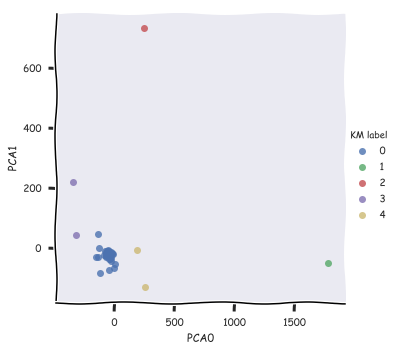

In [27]:
sns.lmplot(x='PCA0',y='PCA1',data=dfT,fit_reg=False,hue='KM label')

In [28]:
pca.explained_variance_ratio_

array([0.8062343, 0.1395959])

In [29]:
# Second project: Fill in NaNs through LSTM

In [30]:
c_lookback = 4
c_lookforward = 4

S = []
for x in xtrain_nm:
    for k in range(len(x)-(c_lookforward+c_lookback+1)):
        S.append(x[k:k+(c_lookforward+c_lookback+1)])
S = np.stack(S,axis=0)

In [31]:
X = S[:,:c_lookback].reshape(-1,c_lookback,1)
y = S[:,c_lookback].reshape(-1,1)
Z = S[:,c_lookback+1:].reshape(-1,c_lookforward,1)

Zinv = Z[:,range(Z.shape[1]-1,-1,-1)].reshape(-1,c_lookforward,1)

Xtrain,Xtest,ytrain,ytest,Ztrain,Ztest = train_test_split(X,y,Zinv,test_size=0.2,shuffle=True)

In [32]:
in_forward = Input(shape=(c_lookback,1,))
in_backward = Input(shape=(c_lookforward,1,))

lstm_forward = LSTM(units=1,dropout=0,activation=tf.nn.relu,return_sequences=False,return_state=False)
lstm_backward = LSTM(units=1,dropout=0,activation=tf.nn.relu,return_sequences=False,return_state=False)
dense0 = Dense(units=10,activation=tf.nn.relu)
dense1 = Dense(units=1,activation='linear')

x0 = lstm_forward(in_forward)
x1 = lstm_backward(in_backward)

x = concatenate([x0,x1])
x = dense0(x)
out0 = dense1(x)

model_full = Model(inputs=[in_forward,in_backward],outputs=out0)
model_full.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

model_full.fit([Xtrain,Ztrain],ytrain,batch_size=3,epochs=5,validation_split=0.2)

Train on 11721 samples, validate on 2931 samples
Epoch 1/5
11721/11721 [==============================] - 32s 3ms/step - loss: 105.4457 - acc: 0.0000e+00 - val_loss: 85.8639 - val_acc: 0.0000e+00
Epoch 2/5
11721/11721 [==============================] - 30s 3ms/step - loss: 96.0799 - acc: 0.0000e+00 - val_loss: 79.1491 - val_acc: 0.0000e+00
Epoch 3/5
11721/11721 [==============================] - 33s 3ms/step - loss: 91.3819 - acc: 0.0000e+00 - val_loss: 75.3689 - val_acc: 0.0000e+00
Epoch 4/5
11721/11721 [==============================] - 32s 3ms/step - loss: 85.4898 - acc: 0.0000e+00 - val_loss: 76.0641 - val_acc: 0.0000e+00
Epoch 5/5
11721/11721 [==============================] - 33s 3ms/step - loss: 88.1285 - acc: 0.0000e+00 - val_loss: 124.1588 - val_acc: 0.0000e+00


In [33]:
model_full.evaluate([Xtest,Ztest],ytest)

3663/3663 [==============================] - 0s 84us/step


[106.25697698275509, 0.0]

In [34]:
for testid in range(Xtest.shape[0]):

    xx = Xtest[testid,:].reshape(-1,c_lookback,1)
    zz = Ztest[testid,:].reshape(-1,c_lookforward,1)

    y_real = ytest[testid].reshape(-1,1)
    y_pred = model_full.predict([xx,zz]).reshape(-1,1)

    print('Real:%f <-> Pred:%f  -->  Delta=%f'%(y_real,y_pred,np.abs(y_real-y_pred)))

Real:16.241548 <-> Pred:16.321873  -->  Delta=0.080325
Real:-1.055183 <-> Pred:-0.888129  -->  Delta=0.167054
Real:-25.035038 <-> Pred:-6.387481  -->  Delta=18.647557
Real:3.892350 <-> Pred:4.219934  -->  Delta=0.327584
Real:-2.871905 <-> Pred:-2.121168  -->  Delta=0.750737
Real:0.667386 <-> Pred:1.005029  -->  Delta=0.337643
Real:0.105859 <-> Pred:0.266322  -->  Delta=0.160463
Real:0.913415 <-> Pred:1.268361  -->  Delta=0.354946
Real:-2.023786 <-> Pred:-1.582931  -->  Delta=0.440856
Real:-2.120836 <-> Pred:-4.125061  -->  Delta=2.004225
Real:-0.684883 <-> Pred:-0.718637  -->  Delta=0.033755
Real:4.879588 <-> Pred:5.231710  -->  Delta=0.352122
Real:1.140690 <-> Pred:1.553090  -->  Delta=0.412400
Real:-0.239341 <-> Pred:-0.131718  -->  Delta=0.107623
Real:0.905487 <-> Pred:1.281839  -->  Delta=0.376353
Real:-1.432956 <-> Pred:-1.083534  -->  Delta=0.349422
Real:32.047718 <-> Pred:35.614582  -->  Delta=3.566864
Real:-1.546332 <-> Pred:-1.007138  -->  Delta=0.539195
Real:11.498095 <-> Pre

Real:3.103511 <-> Pred:3.882286  -->  Delta=0.778775
Real:-0.534313 <-> Pred:-0.202940  -->  Delta=0.331374
Real:-1.237650 <-> Pred:-0.394643  -->  Delta=0.843007
Real:17.580360 <-> Pred:17.280754  -->  Delta=0.299606
Real:-86.095862 <-> Pred:-6.387481  -->  Delta=79.708381
Real:0.598287 <-> Pred:0.821236  -->  Delta=0.222949
Real:0.175108 <-> Pred:0.359579  -->  Delta=0.184471
Real:-5.321905 <-> Pred:-5.415938  -->  Delta=0.094034
Real:1.711462 <-> Pred:2.531456  -->  Delta=0.819993
Real:13.321701 <-> Pred:13.397615  -->  Delta=0.075915
Real:-0.746332 <-> Pred:-0.470110  -->  Delta=0.276222
Real:-0.625663 <-> Pred:-0.323987  -->  Delta=0.301676
Real:-0.642614 <-> Pred:-0.294261  -->  Delta=0.348353
Real:-0.422035 <-> Pred:-0.295048  -->  Delta=0.126987
Real:0.877386 <-> Pred:1.119332  -->  Delta=0.241946
Real:-76.545862 <-> Pred:-6.387481  -->  Delta=70.158381
Real:88.554138 <-> Pred:92.108292  -->  Delta=3.554154
Real:-8.244420 <-> Pred:-6.196487  -->  Delta=2.047933
Real:-1.277082 <

Real:-72.145862 <-> Pred:-6.387481  -->  Delta=65.758381
Real:1.279790 <-> Pred:2.322779  -->  Delta=1.042989
Real:2.695714 <-> Pred:3.149429  -->  Delta=0.453715
Real:2.078192 <-> Pred:2.492091  -->  Delta=0.413899
Real:8.962364 <-> Pred:10.173658  -->  Delta=1.211294
Real:-1.423938 <-> Pred:-1.801232  -->  Delta=0.377294
Real:15.306818 <-> Pred:11.191643  -->  Delta=4.115175
Real:-0.097996 <-> Pred:-4.137996  -->  Delta=4.040000
Real:2.938092 <-> Pred:3.120520  -->  Delta=0.182428
Real:-0.812956 <-> Pred:-0.368733  -->  Delta=0.444223
Real:-4.185799 <-> Pred:-5.146896  -->  Delta=0.961097
Real:2.679637 <-> Pred:3.185102  -->  Delta=0.505465
Real:1.271790 <-> Pred:1.501587  -->  Delta=0.229797
Real:-3.597996 <-> Pred:-5.462736  -->  Delta=1.864740
Real:-5.531899 <-> Pred:-5.775013  -->  Delta=0.243114
Real:-2.866826 <-> Pred:-2.953519  -->  Delta=0.086693
Real:-0.159341 <-> Pred:-0.082804  -->  Delta=0.076537
Real:0.696412 <-> Pred:0.884581  -->  Delta=0.188169
Real:10.070862 <-> Pred

Real:3.029574 <-> Pred:4.038199  -->  Delta=1.008625
Real:-1.386486 <-> Pred:-1.262699  -->  Delta=0.123787
Real:-0.799924 <-> Pred:-0.634566  -->  Delta=0.165357
Real:0.002350 <-> Pred:1.026457  -->  Delta=1.024107
Real:0.316357 <-> Pred:0.287768  -->  Delta=0.028589
Real:0.118308 <-> Pred:0.439305  -->  Delta=0.320998
Real:1.719280 <-> Pred:1.386649  -->  Delta=0.332631
Real:-1.654352 <-> Pred:-1.233386  -->  Delta=0.420967
Real:-1.313908 <-> Pred:-1.247998  -->  Delta=0.065910
Real:-5.137710 <-> Pred:-5.309207  -->  Delta=0.171497
Real:-1.972956 <-> Pred:-1.503286  -->  Delta=0.469670
Real:-4.461540 <-> Pred:-2.472273  -->  Delta=1.989267
Real:6.013406 <-> Pred:7.302791  -->  Delta=1.289386
Real:-1.160308 <-> Pred:-1.037776  -->  Delta=0.122532
Real:-0.674485 <-> Pred:-0.536563  -->  Delta=0.137922
Real:39.079262 <-> Pred:40.057621  -->  Delta=0.978359
Real:8.379759 <-> Pred:8.560242  -->  Delta=0.180483
Real:0.078408 <-> Pred:0.209926  -->  Delta=0.131518
Real:0.321548 <-> Pred:0.5

Real:-1.222956 <-> Pred:-0.949163  -->  Delta=0.273793
Real:-5.189543 <-> Pred:-5.490268  -->  Delta=0.300725
Real:-0.900651 <-> Pred:-0.712104  -->  Delta=0.188547
Real:0.224912 <-> Pred:0.421126  -->  Delta=0.196214
Real:-0.757650 <-> Pred:-0.531643  -->  Delta=0.226006
Real:0.183159 <-> Pred:0.373509  -->  Delta=0.190350
Real:-3.288299 <-> Pred:-2.413070  -->  Delta=0.875229
Real:-1.776251 <-> Pred:-1.313190  -->  Delta=0.463061
Real:0.548617 <-> Pred:0.702755  -->  Delta=0.154138
Real:-4.603799 <-> Pred:-4.509535  -->  Delta=0.094264
Real:-0.293341 <-> Pred:-0.159572  -->  Delta=0.133769
Real:-1.262708 <-> Pred:-1.023088  -->  Delta=0.239620
Real:-7.228120 <-> Pred:-5.844505  -->  Delta=1.383615
Real:-2.225213 <-> Pred:-2.337970  -->  Delta=0.112757
Real:1.011548 <-> Pred:1.016971  -->  Delta=0.005423
Real:0.564490 <-> Pred:0.833685  -->  Delta=0.269195
Real:9.426862 <-> Pred:14.452436  -->  Delta=5.025575
Real:-2.752820 <-> Pred:-2.211540  -->  Delta=0.541280
Real:-40.497238 <-> P

Real:-5.504308 <-> Pred:-5.931554  -->  Delta=0.427246
Real:-50.145862 <-> Pred:-6.387481  -->  Delta=43.758381
Real:-2.277063 <-> Pred:-1.827413  -->  Delta=0.449650
Real:-2.953720 <-> Pred:-1.952159  -->  Delta=1.001561
Real:0.387812 <-> Pred:0.416983  -->  Delta=0.029171
Real:0.112659 <-> Pred:0.250211  -->  Delta=0.137552
Real:0.130576 <-> Pred:0.416311  -->  Delta=0.285734
Real:1.561717 <-> Pred:1.973917  -->  Delta=0.412199
Real:0.714187 <-> Pred:1.254061  -->  Delta=0.539875
Real:-1.905386 <-> Pred:-1.779560  -->  Delta=0.125826
Real:-0.194508 <-> Pred:0.333857  -->  Delta=0.528365
Real:-2.806912 <-> Pred:-2.465929  -->  Delta=0.340983
Real:-0.523852 <-> Pred:-0.336334  -->  Delta=0.187518
Real:-2.945312 <-> Pred:-2.438022  -->  Delta=0.507289
Real:0.609357 <-> Pred:1.043559  -->  Delta=0.434202
Real:1.421615 <-> Pred:1.669087  -->  Delta=0.247472
Real:-12.663340 <-> Pred:-6.387481  -->  Delta=6.275859
Real:6.270801 <-> Pred:6.737478  -->  Delta=0.466677
Real:1.545764 <-> Pred:1

Real:0.218095 <-> Pred:0.298207  -->  Delta=0.080112
Real:81.004138 <-> Pred:87.274872  -->  Delta=6.270734
Real:-2.641594 <-> Pred:-1.550695  -->  Delta=1.090900
Real:-0.526541 <-> Pred:-0.326806  -->  Delta=0.199735
Real:-0.737051 <-> Pred:-0.770834  -->  Delta=0.033783
Real:-1.506452 <-> Pred:-0.558622  -->  Delta=0.947830
Real:-20.407996 <-> Pred:-6.387481  -->  Delta=14.020515
Real:-0.168088 <-> Pred:0.328772  -->  Delta=0.496860
Real:1.170548 <-> Pred:1.982852  -->  Delta=0.812304
Real:1.091487 <-> Pred:1.182184  -->  Delta=0.090697
Real:-1.601812 <-> Pred:-1.182197  -->  Delta=0.419615
Real:-21.034182 <-> Pred:-6.387481  -->  Delta=14.646701
Real:2.143668 <-> Pred:2.289991  -->  Delta=0.146323
Real:0.332887 <-> Pred:0.722227  -->  Delta=0.389340
Real:-1.192941 <-> Pred:-0.968907  -->  Delta=0.224034
Real:0.339315 <-> Pred:0.530283  -->  Delta=0.190968
Real:-1.799810 <-> Pred:-1.593050  -->  Delta=0.206760
Real:-19.745862 <-> Pred:-6.387481  -->  Delta=13.358381
Real:-4.284640 <-

Real:21.837718 <-> Pred:25.409554  -->  Delta=3.571835
Real:0.381587 <-> Pred:0.368585  -->  Delta=0.013002
Real:0.374512 <-> Pred:0.547812  -->  Delta=0.173300
Real:-8.282440 <-> Pred:-6.387481  -->  Delta=1.894959
Real:0.547386 <-> Pred:0.799467  -->  Delta=0.252081
Real:-0.085538 <-> Pred:0.263973  -->  Delta=0.349511
Real:-0.922614 <-> Pred:-0.916109  -->  Delta=0.006505
Real:45.121062 <-> Pred:33.932320  -->  Delta=11.188742
Real:-1.312288 <-> Pred:-1.113780  -->  Delta=0.198509
Real:2.241592 <-> Pred:2.665465  -->  Delta=0.423873
Real:0.550076 <-> Pred:1.116449  -->  Delta=0.566373
Real:18.434860 <-> Pred:20.412792  -->  Delta=1.977932
Real:70.321662 <-> Pred:58.310547  -->  Delta=12.011115
Real:0.337044 <-> Pred:1.052253  -->  Delta=0.715209
Real:0.262515 <-> Pred:0.071441  -->  Delta=0.191074
Real:-2.191508 <-> Pred:-1.490639  -->  Delta=0.700869
Real:1.472612 <-> Pred:1.716392  -->  Delta=0.243780
Real:-0.072163 <-> Pred:0.064612  -->  Delta=0.136775
Real:-5.913343 <-> Pred:-5

Real:1.433049 <-> Pred:1.595994  -->  Delta=0.162945
Real:-2.383412 <-> Pred:-2.057615  -->  Delta=0.325796
Real:0.817044 <-> Pred:1.185951  -->  Delta=0.368908
Real:1.285937 <-> Pred:1.643820  -->  Delta=0.357883
Real:-0.949924 <-> Pred:-0.812674  -->  Delta=0.137250
Real:-2.341326 <-> Pred:-3.566539  -->  Delta=1.225213
Real:3.513668 <-> Pred:3.785959  -->  Delta=0.272291
Real:-5.341905 <-> Pred:-5.597432  -->  Delta=0.255527
Real:-2.176763 <-> Pred:-1.842801  -->  Delta=0.333962
Real:-29.632782 <-> Pred:-6.387481  -->  Delta=23.245301
Real:-1.761335 <-> Pred:-1.345352  -->  Delta=0.415983
Real:-5.392943 <-> Pred:-5.578352  -->  Delta=0.185409
Real:10.642004 <-> Pred:9.807434  -->  Delta=0.834570
Real:-12.032282 <-> Pred:-6.387481  -->  Delta=5.644801
Real:0.789692 <-> Pred:1.073687  -->  Delta=0.283995
Real:-9.008452 <-> Pred:-6.273954  -->  Delta=2.734498
Real:1.627914 <-> Pred:2.185184  -->  Delta=0.557270
Real:-31.256682 <-> Pred:-6.387481  -->  Delta=24.869201
Real:-2.454852 <->

Real:7.093801 <-> Pred:6.618598  -->  Delta=0.475202
Real:-3.342252 <-> Pred:-3.057721  -->  Delta=0.284531
Real:6.704701 <-> Pred:6.768030  -->  Delta=0.063329
Real:1.684917 <-> Pred:2.309868  -->  Delta=0.624951
Real:0.467764 <-> Pred:0.987333  -->  Delta=0.519569
Real:-14.132282 <-> Pred:-6.387481  -->  Delta=7.744801
Real:26.507718 <-> Pred:21.513630  -->  Delta=4.994088
Real:0.137859 <-> Pred:0.296376  -->  Delta=0.158517
Real:-4.348452 <-> Pred:-5.350801  -->  Delta=1.002349
Real:17.668760 <-> Pred:16.262560  -->  Delta=1.406200
Real:-0.840883 <-> Pred:-0.497137  -->  Delta=0.343746
Real:-6.156599 <-> Pred:-6.158838  -->  Delta=0.002239
Real:2.632457 <-> Pred:3.278224  -->  Delta=0.645767
Real:-40.330238 <-> Pred:-6.387481  -->  Delta=33.942757
Real:-1.651608 <-> Pred:-1.322964  -->  Delta=0.328644
Real:-3.056594 <-> Pred:-2.993435  -->  Delta=0.063159
Real:2.585357 <-> Pred:3.062173  -->  Delta=0.476816
Real:22.092004 <-> Pred:22.954649  -->  Delta=0.862645
Real:0.289208 <-> Pre

Real:-1.237650 <-> Pred:-0.623885  -->  Delta=0.613765
Real:2.722548 <-> Pred:2.641857  -->  Delta=0.080691
Real:4.651892 <-> Pred:5.151778  -->  Delta=0.499886
Real:-9.432526 <-> Pred:-6.387481  -->  Delta=3.045044
Real:1.179249 <-> Pred:1.838048  -->  Delta=0.658800
Real:4.312004 <-> Pred:5.113986  -->  Delta=0.801982
Real:-2.232956 <-> Pred:-1.367813  -->  Delta=0.865144
Real:0.164259 <-> Pred:0.345538  -->  Delta=0.181279
Real:0.420165 <-> Pred:0.736204  -->  Delta=0.316039
Real:0.828065 <-> Pred:1.065728  -->  Delta=0.237663
Real:3.611664 <-> Pred:4.652433  -->  Delta=1.040769
Real:-7.481936 <-> Pred:-6.230153  -->  Delta=1.251783
Real:0.900787 <-> Pred:1.146351  -->  Delta=0.245565
Real:-0.982956 <-> Pred:-0.758651  -->  Delta=0.224306
Real:-1.237650 <-> Pred:-0.598869  -->  Delta=0.638780
Real:1.428215 <-> Pred:1.612353  -->  Delta=0.184138
Real:-2.320140 <-> Pred:-1.191534  -->  Delta=1.128606
Real:0.461548 <-> Pred:2.165706  -->  Delta=1.704159
Real:-0.340651 <-> Pred:-0.24213

Real:0.624065 <-> Pred:0.785107  -->  Delta=0.161042
Real:-0.792236 <-> Pred:-0.703243  -->  Delta=0.088993
Real:0.457617 <-> Pred:0.603742  -->  Delta=0.146124
Real:-0.511963 <-> Pred:-0.490220  -->  Delta=0.021743
Real:0.461437 <-> Pred:0.576751  -->  Delta=0.115314
Real:11.493862 <-> Pred:13.327288  -->  Delta=1.833426
Real:-42.246138 <-> Pred:-6.387481  -->  Delta=35.858657
Real:-1.126332 <-> Pred:-0.869394  -->  Delta=0.256939
Real:-2.218236 <-> Pred:-3.378447  -->  Delta=1.160211
Real:-5.191905 <-> Pred:-5.410826  -->  Delta=0.218921
Real:0.819814 <-> Pred:0.949618  -->  Delta=0.129804
Real:-1.878126 <-> Pred:-1.324621  -->  Delta=0.553504
Real:-0.932614 <-> Pred:-0.745038  -->  Delta=0.187576
Real:-5.389136 <-> Pred:-5.637044  -->  Delta=0.247908
Real:0.904515 <-> Pred:1.197108  -->  Delta=0.292593
Real:-2.167650 <-> Pred:-1.525518  -->  Delta=0.642131
Real:-0.043108 <-> Pred:0.088191  -->  Delta=0.131299
Real:0.663715 <-> Pred:0.851785  -->  Delta=0.188070
Real:17.766960 <-> Pr

Real:-1.175389 <-> Pred:-0.938517  -->  Delta=0.236872
Real:-0.052608 <-> Pred:0.128213  -->  Delta=0.180821
Real:0.041812 <-> Pred:0.031041  -->  Delta=0.010771
Real:-1.047650 <-> Pred:-0.948037  -->  Delta=0.099613
Real:-0.089641 <-> Pred:0.094659  -->  Delta=0.184300
Real:-1.408426 <-> Pred:-1.309074  -->  Delta=0.099351
Real:-1.257650 <-> Pred:-0.679053  -->  Delta=0.578596
Real:-2.114341 <-> Pred:-1.727494  -->  Delta=0.386847
Real:4.548095 <-> Pred:4.875013  -->  Delta=0.326918
Real:1.903164 <-> Pred:2.483585  -->  Delta=0.580421
Real:-12.412282 <-> Pred:-6.387481  -->  Delta=6.024801
Real:-1.735141 <-> Pred:-1.081283  -->  Delta=0.653858
Real:-0.200435 <-> Pred:-0.058767  -->  Delta=0.141668
Real:-2.456712 <-> Pred:-2.112640  -->  Delta=0.344072
Real:-0.692388 <-> Pred:-0.650115  -->  Delta=0.042273
Real:3.332588 <-> Pred:3.912446  -->  Delta=0.579857
Real:-1.248452 <-> Pred:-0.716168  -->  Delta=0.532284
Real:34.507718 <-> Pred:23.892708  -->  Delta=10.615010
Real:-0.039463 <->

Real:-2.216594 <-> Pred:-1.139921  -->  Delta=1.076673
Real:-1.199924 <-> Pred:-0.933754  -->  Delta=0.266169
Real:0.608948 <-> Pred:0.657331  -->  Delta=0.048384
Real:-0.528851 <-> Pred:-0.536783  -->  Delta=0.007932
Real:-78.745862 <-> Pred:-6.387481  -->  Delta=72.358381
Real:0.388692 <-> Pred:0.555933  -->  Delta=0.167241
Real:0.545212 <-> Pred:0.466262  -->  Delta=0.078949
Real:1.077762 <-> Pred:0.347711  -->  Delta=0.730051
Real:-0.492935 <-> Pred:-0.277566  -->  Delta=0.215369
Real:3.102762 <-> Pred:3.142788  -->  Delta=0.040026
Real:-4.920726 <-> Pred:-5.572523  -->  Delta=0.651798
Real:-3.750820 <-> Pred:-5.029936  -->  Delta=1.279116
Real:1.443668 <-> Pred:1.848007  -->  Delta=0.404339
Real:11.454062 <-> Pred:18.827684  -->  Delta=7.373623
Real:-0.499924 <-> Pred:-0.479682  -->  Delta=0.020241
Real:4.290411 <-> Pred:5.551260  -->  Delta=1.260849
Real:-0.208626 <-> Pred:1.107248  -->  Delta=1.315873
Real:-0.824924 <-> Pred:-0.794344  -->  Delta=0.030580
Real:0.422749 <-> Pred:

Real:-1.106332 <-> Pred:-0.873803  -->  Delta=0.232530
Real:-0.623924 <-> Pred:-0.554714  -->  Delta=0.069210
Real:-2.173089 <-> Pred:-1.894424  -->  Delta=0.278665
Real:-29.709182 <-> Pred:-6.387481  -->  Delta=23.321701
Real:3.368095 <-> Pred:4.182613  -->  Delta=0.814518
Real:86.856962 <-> Pred:80.657730  -->  Delta=6.199231
Real:-1.262708 <-> Pred:-0.995801  -->  Delta=0.266907
Real:0.510892 <-> Pred:0.695147  -->  Delta=0.184255
Real:-0.534924 <-> Pred:-0.450211  -->  Delta=0.084713
Real:-6.489243 <-> Pred:-6.038571  -->  Delta=0.450672
Real:-0.964708 <-> Pred:-0.392559  -->  Delta=0.572149
Real:3.658288 <-> Pred:4.397018  -->  Delta=0.738730
Real:-1.070563 <-> Pred:-0.760700  -->  Delta=0.309863
Real:3.944874 <-> Pred:3.808911  -->  Delta=0.135964
Real:1.017274 <-> Pred:0.564626  -->  Delta=0.452649
Real:0.720949 <-> Pred:0.870431  -->  Delta=0.149482
Real:-0.748924 <-> Pred:-0.602085  -->  Delta=0.146838
Real:2.567017 <-> Pred:2.788161  -->  Delta=0.221143
Real:56.218862 <-> Pre

Real:2.074557 <-> Pred:1.638349  -->  Delta=0.436208
Real:4.510611 <-> Pred:5.035292  -->  Delta=0.524682
Real:3.214464 <-> Pred:3.572182  -->  Delta=0.357718
Real:-1.292614 <-> Pred:-1.013943  -->  Delta=0.278671
Real:-64.245862 <-> Pred:-6.387481  -->  Delta=57.858381
Real:0.211548 <-> Pred:-0.178842  -->  Delta=0.390389
Real:16.311548 <-> Pred:16.003899  -->  Delta=0.307649
Real:-1.210308 <-> Pred:-0.008439  -->  Delta=1.201870
Real:-0.152141 <-> Pred:-0.035795  -->  Delta=0.116346
Real:0.888412 <-> Pred:1.219550  -->  Delta=0.331138
Real:4.719211 <-> Pred:5.158421  -->  Delta=0.439211
Real:0.313612 <-> Pred:0.550793  -->  Delta=0.237181
Real:3.296787 <-> Pred:3.603455  -->  Delta=0.306669
Real:1.498362 <-> Pred:2.429151  -->  Delta=0.930789
Real:-1.507038 <-> Pred:-1.192730  -->  Delta=0.314308
Real:0.178815 <-> Pred:0.276184  -->  Delta=0.097369
Real:0.621088 <-> Pred:0.902190  -->  Delta=0.281101
Real:14.481548 <-> Pred:12.828220  -->  Delta=1.653327
Real:-1.249924 <-> Pred:-1.00

Real:5.790201 <-> Pred:6.556405  -->  Delta=0.766204
Real:-0.679135 <-> Pred:-0.574704  -->  Delta=0.104431
Real:-0.472614 <-> Pred:-0.373660  -->  Delta=0.098954
Real:0.109865 <-> Pred:0.479566  -->  Delta=0.369701
Real:0.122759 <-> Pred:0.257408  -->  Delta=0.134649
Real:-49.464538 <-> Pred:-6.387481  -->  Delta=43.077057
Real:0.298587 <-> Pred:0.858732  -->  Delta=0.560146
Real:-1.395741 <-> Pred:-2.252587  -->  Delta=0.856846
Real:-0.012956 <-> Pred:0.348825  -->  Delta=0.361781
Real:-7.497996 <-> Pred:-5.448129  -->  Delta=2.049867
Real:2.500557 <-> Pred:3.119078  -->  Delta=0.618521
Real:0.810308 <-> Pred:1.067174  -->  Delta=0.256866
Real:5.319557 <-> Pred:6.035609  -->  Delta=0.716052
Real:2.816437 <-> Pred:3.277243  -->  Delta=0.460806
Real:1.155749 <-> Pred:1.446288  -->  Delta=0.290539
Real:0.778015 <-> Pred:1.332029  -->  Delta=0.554015
Real:-3.677638 <-> Pred:-2.021097  -->  Delta=1.656541
Real:0.183159 <-> Pred:0.380767  -->  Delta=0.197608
Real:1.152014 <-> Pred:1.436416

Real:-0.606332 <-> Pred:-0.381270  -->  Delta=0.225062
Real:0.677386 <-> Pred:0.933964  -->  Delta=0.256578
Real:-0.224263 <-> Pred:-0.062190  -->  Delta=0.162073
Real:-0.507488 <-> Pred:-0.373404  -->  Delta=0.134084
Real:-3.881905 <-> Pred:-3.669411  -->  Delta=0.212494
Real:-0.708192 <-> Pred:-0.629510  -->  Delta=0.078682
Real:6.049301 <-> Pred:7.395473  -->  Delta=1.346172
Real:4.921318 <-> Pred:3.886654  -->  Delta=1.034664
Real:3.748615 <-> Pred:4.428639  -->  Delta=0.680024
Real:2.337011 <-> Pred:3.104657  -->  Delta=0.767646
Real:28.327718 <-> Pred:20.341545  -->  Delta=7.986173
Real:-39.781738 <-> Pred:-6.387481  -->  Delta=33.394257
Real:-0.922956 <-> Pred:-0.747197  -->  Delta=0.175760
Real:7.242004 <-> Pred:9.004341  -->  Delta=1.762337
Real:0.389612 <-> Pred:0.459259  -->  Delta=0.069647
Real:-4.821905 <-> Pred:-5.146420  -->  Delta=0.324516
Real:-0.242956 <-> Pred:-0.221232  -->  Delta=0.021724
Real:-25.631238 <-> Pred:-6.387481  -->  Delta=19.243757
Real:-0.864392 <-> P

In [35]:
# Third project: Fill NaNs through Hopfield Network

In [52]:
seqlen = 3

S = []
for seqid in range(xtrain_nm.shape[0]):
    for k in range(xtrain_nm.shape[1]-seqlen):
        S.append(xtrain_nm[seqid,k:k+seqlen])
S = np.stack(S,axis=0)

In [53]:
h = rnd.randn(seqlen)

In [82]:
W = rnd.randn(seqlen,seqlen)

for i in range(W.shape[0]):
    for j in range(i+1):
        if i==j: 
            W[i,j] = 0
            continue
        W[i,j] = W[j,i]

In [83]:
W

array([[ 0.        , -0.19155288, -0.69653876],
       [-0.19155288,  0.        , -0.10287109],
       [-0.69653876, -0.10287109,  0.        ]])

In [98]:
a0 = S[0]

a = np.zeros(shape=a0.shape)
for i in range(W.shape[0]):
    for j in range(W.shape[1]):
        a[i] += W[i,j]*a0[j] 

In [105]:
a0-a

array([-10.69627645,  -7.60684122, -10.38909072])

In [100]:
a

array([5.36437169, 1.64493646, 4.32718596])

In [104]:
a0

array([-5.33190476, -5.96190476, -6.06190476])